# Import

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import layers, regularizers


# Data Collection

Download dataset as zip in this: https://www.kaggle.com/datasets/meirnizri/cellphones-recommendations/data

In [2]:
# Path ke file ZIP
zip_file_path = "archive.zip"
extract_to_path = "dataset/"

# Buat direktori tujuan jika belum ada
os.makedirs(extract_to_path, exist_ok=True)

# Ekstraksi file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files have been extracted to: {extract_to_path}")

Files have been extracted to: dataset/


# Data Understanding

Pada tahap ini akan dilakukan pemuatan tiga dataset, menampilkan dimensinya, nama kolomnya, dan mengembalikannya untuk digunakan.

In [2]:
def load_and_explore_datasets(data_path):
    """
    Function to load and explore the datasets. Prints the number of columns, column names (readable),
    and a sample of rows from each dataset.
    """
    try:
        # Load datasets
        cellphones_data = pd.read_csv(data_path + "cellphones data.csv")
        cellphones_ratings = pd.read_csv(data_path + "cellphones ratings.csv")
        cellphones_users = pd.read_csv(data_path + "cellphones users.csv")

        # Confirm successful loading
        print("Datasets berhasil dimuat.\n")

        # Explore 'cellphones_data'
        print(f"'cellphones_data' dimensions: {cellphones_data.shape}")
        print("Columns:")
        for col in cellphones_data.columns:
            print(f"- {col}")
        print("\n")


        # Explore 'cellphones_ratings'
        print(f"'cellphones_ratings' dimensions: {cellphones_ratings.shape}")
        print("Columns:")
        for col in cellphones_ratings.columns:
            print(f"- {col}")
        print("\n")

        # Explore 'cellphones_users'
        print(f"'cellphones_users' dimensions: {cellphones_users.shape}")
        print("Columns:")
        for col in cellphones_users.columns:
            print(f"- {col}")
        print("\n")
        
        return cellphones_data, cellphones_ratings, cellphones_users

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Pastikan file ada di folder yang benar dan nama file sesuai.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# Usage
data_path = "dataset/"  # Sesuaikan jalur folder dataset
cellphones_data, cellphones_ratings, cellphones_users = load_and_explore_datasets(data_path)


Datasets berhasil dimuat.

'cellphones_data' dimensions: (33, 14)
Columns:
- cellphone_id
- brand
- model
- operating system
- internal memory
- RAM
- performance
- main camera
- selfie camera
- battery size
- screen size
- weight
- price
- release date


'cellphones_ratings' dimensions: (990, 3)
Columns:
- user_id
- cellphone_id
- rating


'cellphones_users' dimensions: (99, 4)
Columns:
- user_id
- age
- gender
- occupation




Pada tahap ini akan dilakukan pengecekan struktur setiap DataFrame menggunakan `.info()` untuk memahami jumlah data, kolom, dan tipe datanya.

In [17]:
def display_info(df, df_name):
    """
    Display the .info() of a given DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to inspect.
    - df_name (str): The name of the DataFrame for display purposes.
    """
    print(f"Dataset: {df_name}")
    print("-" * 50)
    df.info()
    print("\n")

display_info(cellphones_data, "cellphones_data")
display_info(cellphones_ratings, "cellphones_ratings")
display_info(cellphones_users, "cellphones_users")

Dataset: cellphones_data
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cellphone_id      33 non-null     int64  
 1   brand             33 non-null     object 
 2   model             33 non-null     object 
 3   operating system  33 non-null     object 
 4   internal memory   33 non-null     int64  
 5   RAM               33 non-null     int64  
 6   performance       33 non-null     float64
 7   main camera       33 non-null     int64  
 8   selfie camera     33 non-null     int64  
 9   battery size      33 non-null     int64  
 10  screen size       33 non-null     float64
 11  weight            33 non-null     int64  
 12  price             33 non-null     int64  
 13  release date      33 non-null     object 
dtypes: float64(2), int64(8), object(4)
memory usage: 3.7+ KB


Datas

Setelah cek keseluruhan data, dataset telah diverifikasi lengkap tanpa missing values signifikan, kecuali kolom `occupation` pada `cellphones_users` memiliki 1 nilai kosong yang perlu ditangani.

# Exploratory Data Analysis (EDA)

Pada tahap ini, akan dilakuakn analisis pada dataset pertama yaitu `Dataset: cellphones_data`

**1. Distribusi Brand**

Pertama, dilakukan analisis jumlah brand, jumlah ponsel per brand, dan visualisasi distribusinya untuk memahami persebaran data ponsel berdasarkan brand.

Jumlah brand: 10
brand
Samsung     8
Apple       6
OnePlus     4
Xiaomi      4
Motorola    4
Google      3
Asus        1
Oppo        1
Vivo        1
Sony        1
Name: count, dtype: int64
Grafik berhasil disimpan di folder 'images/' dengan nama 'brand_distribution.png'.


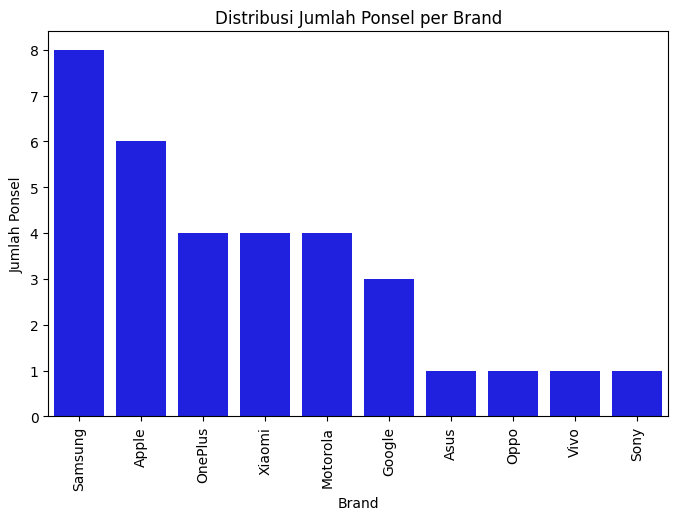

In [21]:
def analyze_brands(data):
    """
    Analyze the number of unique brands, count cellphones per brand,
    and display the distribution as a bar chart with a single color (blue).
    The chart is saved to the 'images/' folder with 900 DPI.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the 'brand' column.
    """
    # Menghitung jumlah brand
    num_brands = len(data['brand'].unique())
    print('Jumlah brand:', num_brands)

    # Menghitung jumlah cellphone masing-masing brand
    brand_counts = data['brand'].value_counts()
    print(brand_counts)

    # Membuat folder 'images/' jika belum ada
    os.makedirs("images", exist_ok=True)

    # Menampilkan dalam bentuk grafik dengan warna biru
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x='brand', order=brand_counts.index, color='blue')
    plt.title("Distribusi Jumlah Ponsel per Brand")
    plt.xticks(rotation=90)
    plt.xlabel("Brand")
    plt.ylabel("Jumlah Ponsel")

    # Save the plot to the 'images/' folder
    plt.savefig("images/brand_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik berhasil disimpan di folder 'images/' dengan nama 'brand_distribution.png'.")

    # Menampilkan grafik
    plt.show()

analyze_brands(cellphones_data)

**Result**

Samsung adalah brand dengan jumlah ponsel terbanyak (8 ponsel), diikuti oleh Apple (6 ponsel), sedangkan Asus, Oppo, Vivo, dan Sony masing-masing hanya memiliki 1 ponsel. Total ada 10 brand.

**2. Distribusi Tipe Setiap Brand**

Selanjutnya, dilakukan identifikasi jumlah model ponsel unik dan menampilkan daftar lengkap model tersebut untuk memahami keragaman data.

In [28]:
def display_models_by_brand(data):
    """
    Display all unique cellphone models grouped by their brand and count the total number of models.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the 'brand' and 'model' columns.
    
    Returns:
    - models_by_brand (dict): A dictionary where keys are brands and values are lists of models.
    """
    # Mengelompokkan model berdasarkan brand
    models_by_brand = data.groupby('brand')['model'].apply(list).to_dict()
    
    # Menghitung jumlah total model
    total_models = sum(len(models) for models in models_by_brand.values())
    print('Jumlah model cellphone:', total_models)
    
    # Menampilkan daftar model berdasarkan brand
    print("\nDaftar model berdasarkan brand:")
    for brand, models in models_by_brand.items():
        print(f"\nBrand: {brand}")
        for model in models:
            print(f"- {model}")
    
    return models_by_brand

models_by_brand = display_models_by_brand(cellphones_data)


Jumlah model cellphone: 33

Daftar model berdasarkan brand:

Brand: Apple
- iPhone SE (2022)
- iPhone 13 Mini
- iPhone 13
- iPhone 13 Pro
- iPhone 13 Pro Max
- iPhone XR

Brand: Asus
- Zenfone 8

Brand: Google
- Pixel 6  
- Pixel 6a
- Pixel 6 Pro 

Brand: Motorola
- Moto G Stylus (2022)
- Moto G Play (2021)
- Moto G Pure
- Moto G Power (2022)

Brand: OnePlus
- Nord N20
- Nord 2T
- 10 Pro
- 10T

Brand: Oppo
- Find X5 Pro

Brand: Samsung
- Galaxy A13
- Galaxy A32
- Galaxy A53
- Galaxy S22
- Galaxy S22 Plus
- Galaxy S22 Ultra
- Galaxy Z Flip 3
- Galaxy Z Fold 3

Brand: Sony
- Xperia Pro

Brand: Vivo
- X80 Pro

Brand: Xiaomi
- Redmi Note 11
- 11T Pro
- 12 Pro
- Poco F4


**3. Distribusi Sistem Operasi**

Tahap ini melakukan analisis distribusi sistem operasi untuk mengetahui jumlah perangkat berdasarkan sistem operasi yang digunakan.

Jumlah Operating System:
operating system
Android    27
iOS         6
Name: count, dtype: int64


Grafik berhasil disimpan di folder 'images/' dengan nama 'operating_system_distribution.png'.


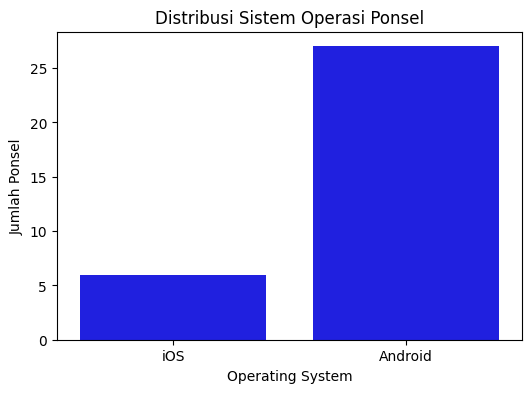

In [23]:
def analyze_operating_system(data):
    """
    Analyze the distribution of operating systems, visualize it, and save the chart as an image.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the 'operating system' column.
    """
    # Menghitung jumlah operating system
    os_counts = data['operating system'].value_counts()
    print("Jumlah Operating System:")
    print(os_counts)
    print("\n")

    # Membuat folder 'images/' jika belum ada
    os.makedirs("images", exist_ok=True)

    # Menampilkan dalam bentuk grafik
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x='operating system', color='blue')
    plt.title("Distribusi Sistem Operasi Ponsel")
    plt.xlabel("Operating System")
    plt.ylabel("Jumlah Ponsel")

    # Save the plot to the 'images/' folder
    plt.savefig("images/operating_system_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik berhasil disimpan di folder 'images/' dengan nama 'operating_system_distribution.png'.")

    # Menampilkan grafik
    plt.show()

analyze_operating_system(cellphones_data)


**Result**

Sebagian besar ponsel menggunakan sistem operasi Android (27 perangkat), sementara sisanya menggunakan iOS (6 perangkat).

**4. Distribusi Memory dan RAM**

Pada tahap ini, dilakukan analisis distribusi kapasitas memori internal dan RAM untuk memahami karakteristik perangkat dalam dataset.

Jumlah Internal Memory:
internal memory
128    20
256     6
64      3
32      3
512     1
Name: count, dtype: int64


Jumlah RAM:
RAM
8     13
4      6
6      6
3      4
12     4
Name: count, dtype: int64


Grafik berhasil disimpan di folder 'images/' dengan nama 'memory_and_ram_distribution.png'.


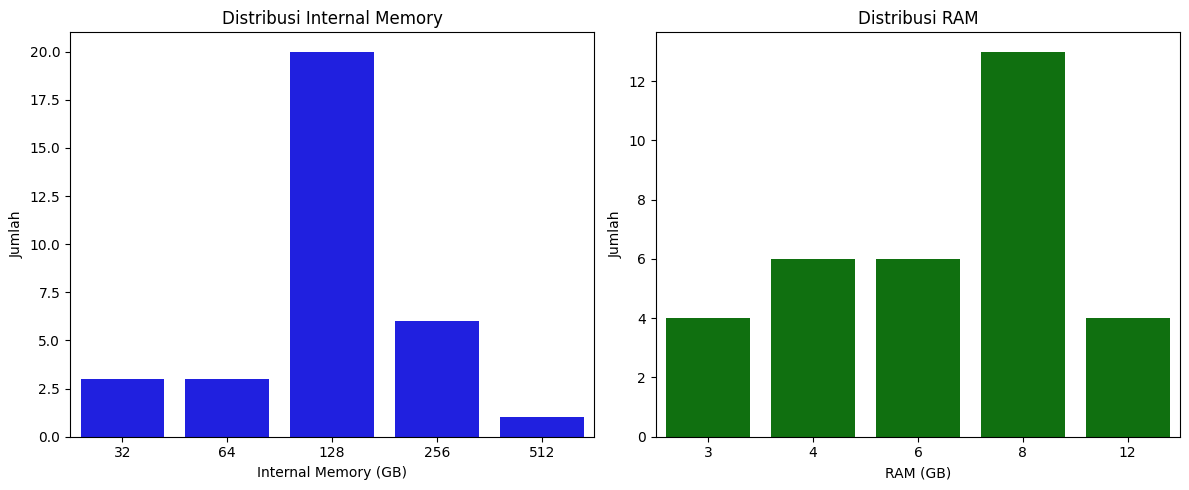

In [26]:
def plot_memory_and_ram(data):
    """
    Plot the distribution of internal memory and RAM in one row with two columns,
    and save the plot to 'images/' folder with 900 DPI.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing 'internal memory' and 'RAM' columns.
    """
    # Menghitung jumlah internal memory
    internalMemory_counts = data['internal memory'].value_counts()
    print("Jumlah Internal Memory:")
    print(internalMemory_counts)
    print("\n")
    
    # Menghitung jumlah RAM
    RAM_counts = data['RAM'].value_counts()
    print("Jumlah RAM:")
    print(RAM_counts)
    print("\n")
    
    # Membuat folder 'images/' jika belum ada
    os.makedirs("images", exist_ok=True)
    
    # Membuat subplot dengan 1 row dan 2 kolom
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot distribusi internal memory
    sns.countplot(ax=axes[0], data=data, x='internal memory', color='blue')
    axes[0].set_title("Distribusi Internal Memory")
    axes[0].set_xlabel("Internal Memory (GB)")
    axes[0].set_ylabel("Jumlah")
    
    # Plot distribusi RAM
    sns.countplot(ax=axes[1], data=data, x='RAM', color='green')
    axes[1].set_title("Distribusi RAM")
    axes[1].set_xlabel("RAM (GB)")
    axes[1].set_ylabel("Jumlah")
    
    # Menyimpan grafik ke folder 'images/' dengan DPI 900
    plt.tight_layout()
    plt.savefig("images/memory_and_ram_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik berhasil disimpan di folder 'images/' dengan nama 'memory_and_ram_distribution.png'.")
    
    # Menampilkan plot
    plt.show()

plot_memory_and_ram(cellphones_data)

**Result**

Sebagian besar perangkat memiliki memori internal 128 GB (20 perangkat) dan RAM 8 GB (13 perangkat).

**5. Distribusi Performance**

Pada tahap ini, dilakukan analisis distribusi nilai performance, termasuk melihat rentang nilai performance dan mengelompokkan data menjadi dua kategori berdasarkan nilai 5.

Range nilai performance: 1.02 - 11.0

Total data dengan performance > 5: 23
Total data dengan performance <= 5: 10
Grafik berhasil disimpan di folder 'images/' dengan nama 'performance_distribution.png'.


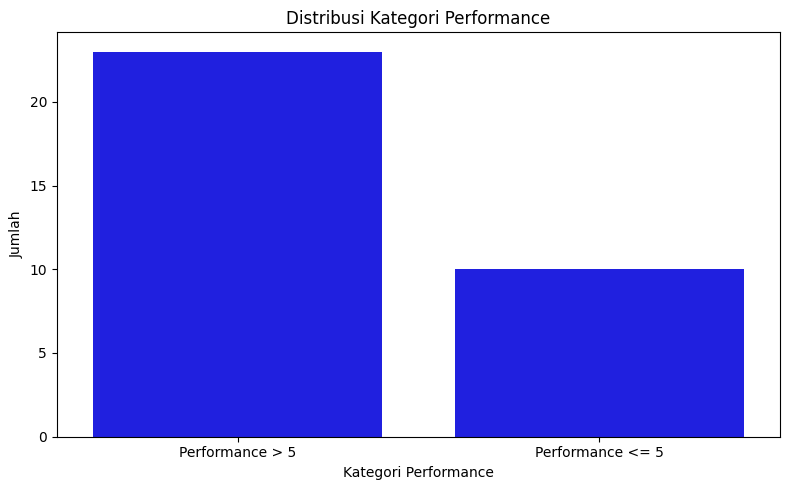

In [28]:
def analyze_performance(data):
    """
    Analyze and visualize the distribution of performance.
    Prints the range of performance values and categorizes them into two groups:
    - Performance > 5
    - Performance <= 5
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the 'performance' column.
    """
    # Print range nilai performance
    min_performance = data['performance'].min()
    max_performance = data['performance'].max()
    print(f"Range nilai performance: {min_performance} - {max_performance}\n")

    # Filter data berdasarkan performance
    performance_above_5 = data[data['performance'] > 5]
    performance_below_5 = data[data['performance'] <= 5]

    # Menghitung total untuk setiap kategori
    total_above_5 = len(performance_above_5)
    total_below_5 = len(performance_below_5)

    print('Total data dengan performance > 5:', total_above_5)
    print('Total data dengan performance <= 5:', total_below_5)

    # Data untuk plotting
    performance_data = pd.DataFrame({
        'Category': ['Performance > 5', 'Performance <= 5'],
        'Total': [total_above_5, total_below_5]
    })

    # Menampilkan dalam bentuk grafik dengan warna biru
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Category', y='Total', data=performance_data, color='blue')
    plt.title("Distribusi Kategori Performance")
    plt.xlabel("Kategori Performance")
    plt.ylabel("Jumlah")
    plt.tight_layout()

    # Save the plot to the 'images/' folder
    os.makedirs("images", exist_ok=True)
    plt.savefig("images/performance_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik berhasil disimpan di folder 'images/' dengan nama 'performance_distribution.png'.")

    plt.show()

analyze_performance(cellphones_data)

**Result**

Rentang nilai performance adalah 1.02 hingga 11.0, dengan 23 data memiliki nilai performance > 5 dan 10 data memiliki nilai performance ≤ 5. Grafik distribusi telah disimpan di folder `images/` dengan nama `performance_distribution.png`.

**6. Distribusi Price**

Pada tahap ini, dilakukan analisis distribusi harga ponsel dengan melihat rentang nilai harga secara keseluruhan dan mengelompokkan data ke dalam lima kategori harga.

Range nilai price: 129 - 1998

Distribusi Kategori Harga:
price_category
0-300        8
300-600     10
600-900     10
900-1200     3
>1200        2
Name: count, dtype: int64


Grafik berhasil disimpan di folder 'images/' dengan nama 'price_distribution.png'.


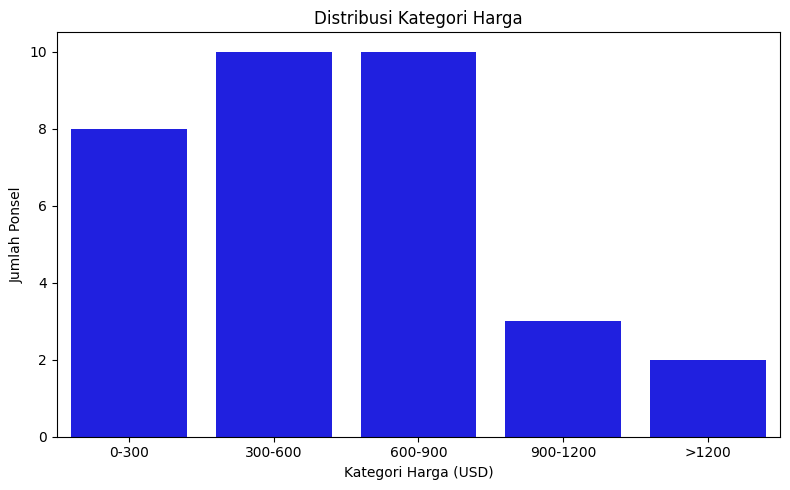

In [29]:
def analyze_price(data):
    """
    Analyze and visualize the distribution of prices by:
    1. Displaying the overall range of prices.
    2. Categorizing prices into groups and visualizing the distribution.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the 'price' column.
    """
    # Melihat rentang nilai price
    min_price = data['price'].min()
    max_price = data['price'].max()
    print(f"Range nilai price: {min_price} - {max_price}\n")

    # Membuat kategori harga
    bins = [0, 300, 600, 900, 1200, max_price + 1] 
    labels = ['0-300', '300-600', '600-900', '900-1200', '>1200']
    data['price_category'] = pd.cut(data['price'], bins=bins, labels=labels, include_lowest=True)

    # Menghitung jumlah data di setiap kategori
    price_category_counts = data['price_category'].value_counts().sort_index()
    print("Distribusi Kategori Harga:")
    print(price_category_counts)
    print("\n")

    # Menampilkan dalam bentuk grafik
    plt.figure(figsize=(8, 5))
    sns.barplot(x=price_category_counts.index, y=price_category_counts.values, color='blue')
    plt.title("Distribusi Kategori Harga")
    plt.xlabel("Kategori Harga (USD)")
    plt.ylabel("Jumlah Ponsel")
    plt.tight_layout()

    # Save the plot to the 'images/' folder
    os.makedirs("images", exist_ok=True)
    plt.savefig("images/price_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik berhasil disimpan di folder 'images/' dengan nama 'price_distribution.png'.")

    # Menampilkan grafik
    plt.show()

# Usage
analyze_price(cellphones_data)


**Result**

Rentang harga ponsel adalah 129 hingga 1998 USD, dengan jumlah ponsel terbanyak dalam kategori 300-600 USD (10 ponsel) dan jumlah paling sedikit dalam kategori >1200 USD (2 ponsel).

**7. Distribusi Rating**

Pada tahap ini, dilakukan analisis terhadap jumlah review yang diberikan oleh user, distribusi jumlah review per tipe ponsel, dan distribusi nilai rating.

---User Review Analysis---

Jumlah review per user:
user_id
0      10
226    10
211    10
208    10
204    10
       ..
95     10
91     10
85     10
84     10
258    10
Name: count, Length: 99, dtype: int64

Nilai unik jumlah review per user: [10]
Semua user memiliki jumlah review yang sama yaitu: 10

---Cellphone Review Analysis---

Jumlah kemunculan per tipe ponsel:
                   model  cellphone_id  Review Count
0     Moto G Play (2021)            30            41
1             Galaxy A32             8            39
2                11T Pro            25            38
3              Pixel 6              15            38
4    Moto G Power (2022)            32            35
5          Redmi Note 11            24            35
6                Poco F4            27            34
7      iPhone 13 Pro Max             4            34
8       Galaxy S22 Ultra            12            32
9        Galaxy Z Flip 3            13            32
10               Nord 2T            19       

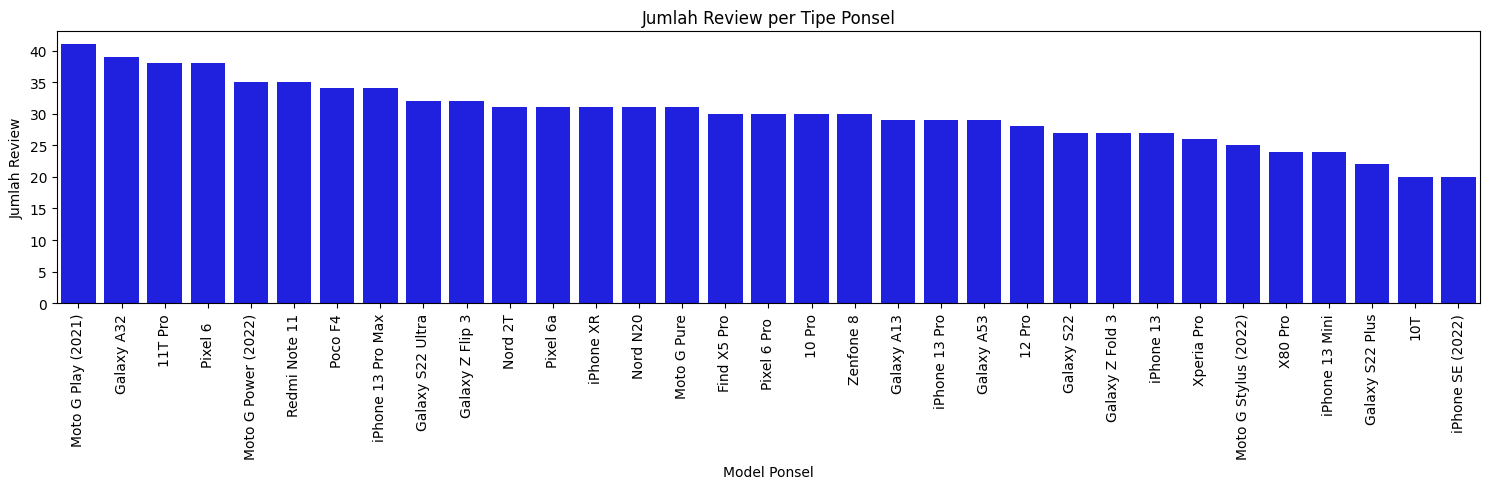


---Rating Distribution Analysis---

Jumlah kemunculan per rating:
rating
1      74
2      44
3      30
4      39
5      68
6     112
7     169
8     195
9     128
10    130
18      1
Name: count, dtype: int64
Rating terkecil: 1
Rating terbesar: 18
Terdapat outliers yaitu rating dengan nilai: 18
Grafik distribusi rating berhasil disimpan di folder 'images/' dengan nama 'rating_distribution.png'.


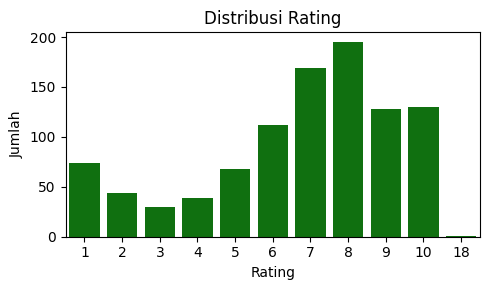

In [32]:
def analyze_ratings(rating, cellphones_data):
    """
    Analyze user reviews, cellphone reviews, and ratings distribution in a single function.
    
    Parameters:
    - rating (pd.DataFrame): The DataFrame containing 'user_id', 'cellphone_id', and 'rating' columns.
    - cellphones_data (pd.DataFrame): The DataFrame containing 'cellphone_id' and 'model' columns.
    """
    print("---User Review Analysis---")
    
    # Menghitung masing-masing user melakukan review berapa kali
    user_review_counts = rating['user_id'].value_counts()
    print("\nJumlah review per user:")
    print(user_review_counts)
    print("\nNilai unik jumlah review per user:", user_review_counts.unique())
    
    if len(user_review_counts.unique()) == 1:
        print("Semua user memiliki jumlah review yang sama yaitu:", user_review_counts.unique()[0])

    print("\n---Cellphone Review Analysis---")
    
    # Menghitung jumlah review per cellphone_id
    cellphone_review_counts = rating['cellphone_id'].value_counts().reset_index()
    cellphone_review_counts.columns = ['cellphone_id', 'Review Count']

    # Menggabungkan dengan nama tipe ponsel
    cellphone_review_named = cellphone_review_counts.merge(
        cellphones_data[['cellphone_id', 'model']],
        on='cellphone_id',
        how='left'
    )

    # Menampilkan jumlah kemunculan per tipe ponsel
    print("\nJumlah kemunculan per tipe ponsel:")
    print(cellphone_review_named[['model', 'cellphone_id', 'Review Count']])

    # Menghitung nilai minimum dan maksimum
    min_reviews = cellphone_review_counts['Review Count'].min()
    max_reviews = cellphone_review_counts['Review Count'].max()
    print(f"\nCellphone paling sedikit direview: {min_reviews}")
    print(f"Cellphone paling banyak direview: {max_reviews}")
    
    # Plotting jumlah review per tipe ponsel
    plt.figure(figsize=(15, 5))
    sns.barplot(x='model', y='Review Count', data=cellphone_review_named, color='blue')
    plt.title("Jumlah Review per Tipe Ponsel")
    plt.xticks(rotation=90)
    plt.xlabel("Model Ponsel")
    plt.ylabel("Jumlah Review")
    plt.tight_layout()
    os.makedirs("images", exist_ok=True)
    plt.savefig("images/cellphone_review_distribution_named.png", dpi=900, bbox_inches='tight')
    print("Grafik jumlah review per tipe ponsel berhasil disimpan di folder 'images/' dengan nama 'cellphone_review_distribution_named.png'.")
    plt.show()

    print("\n---Rating Distribution Analysis---")
    
    # Menghitung distribusi rating
    rating_counts = rating['rating'].value_counts()
    print("\nJumlah kemunculan per rating:")
    print(rating_counts.sort_index())
    
    # Menghitung nilai minimum, maksimum, dan mengecek outliers
    min_rating = rating_counts.index.min()
    max_rating = rating_counts.index.max()
    print(f"Rating terkecil: {min_rating}")
    print(f"Rating terbesar: {max_rating}")
    
    if max_rating > 10:
        print(f"Terdapat outliers yaitu rating dengan nilai: {max_rating}")
    
    # Plotting distribusi rating
    plt.figure(figsize=(5, 3))
    sns.countplot(data=rating, x='rating', color='green')
    plt.title("Distribusi Rating")
    plt.xlabel("Rating")
    plt.ylabel("Jumlah")
    plt.tight_layout()
    plt.savefig("images/rating_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik distribusi rating berhasil disimpan di folder 'images/' dengan nama 'rating_distribution.png'.")
    plt.show()

analyze_ratings(cellphones_ratings, cellphones_data)


**Result**  

1. **User Review Analysis:**  
   Setiap user memberikan jumlah review yang sama, yaitu 10 review.

2. **Cellphone Review Analysis:**  
   - Ponsel yang paling banyak direview adalah **Moto G Play (2021)** dengan 41 review.  
   - Ponsel yang paling sedikit direview adalah **iPhone SE (2022)** dan **10T**, masing-masing dengan 20 review.  
  
3. **Rating Distribution Analysis:**  
   - Nilai rating memiliki rentang dari 1 hingga 18.  
   - Rating terbanyak adalah **8** dengan 195 kemunculan, sedangkan rating paling sedikit adalah **3** dengan 30 kemunculan.  
   - Terdapat outlier pada nilai rating, yaitu **18**.  


**8. Distribusi Users**

Pada athap ini, dilakukan analisis data pengguna berdasarkan usia, gender, dan pekerjaan untuk memahami karakteristik demografis pengguna.

---User Age Analysis---

Jumlah kemunculan age:
age
21     1
23     1
25    12
27     3
28     3
29     5
30     6
31     4
32    10
33     5
34     3
35     3
36     1
37     4
38     5
39     3
40     2
41     2
42     4
43     1
45     1
46     3
48     2
49     2
50     5
55     1
56     2
57     1
58     2
61     2
Name: count, dtype: int64

Usia paling muda: 21
Usia paling tua: 61
Usia dengan jumlah terbanyak adalah 25 dengan jumlah 12.
Grafik distribusi usia berhasil disimpan di folder 'images/' dengan nama 'user_age_distribution.png'.


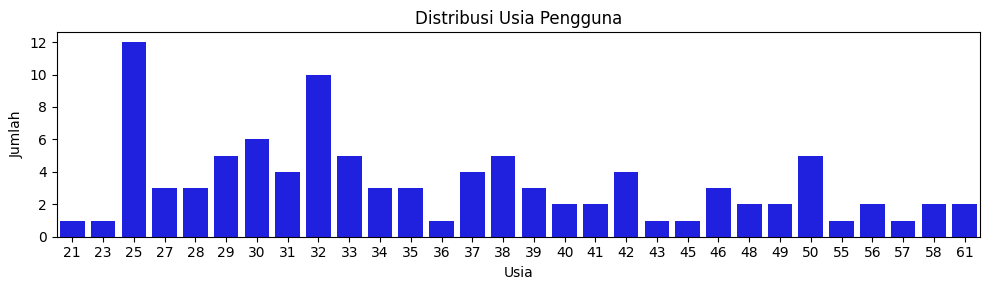


---User Gender Analysis---

Jumlah kemunculan gender:
gender
-Select Gender-     3
Female             46
Male               50
Name: count, dtype: int64
Terdapat outliers yaitu: '-Select Gender-'.
Grafik distribusi gender berhasil disimpan di folder 'images/' dengan nama 'user_gender_distribution.png'.


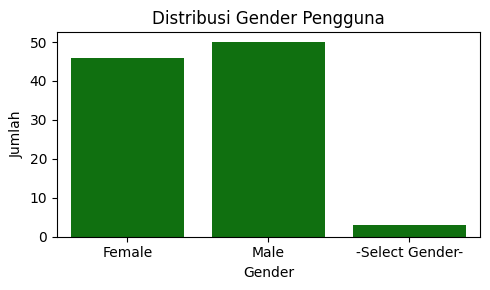


---User Occupation Analysis---
Jumlah occupation: 45

Jumlah kemunculan occupation:
occupation
accountant                           2
administrative officer               5
administrator                        1
banking                              1
business                             1
computer technician                  1
construction                         2
data analyst                         2
education                            2
executive                            1
executive manager                    1
finance                              2
healthare                            1
healthcare                           2
homemaker                            1
ict officer                          1
information                          1
information technology              12
it                                   6
manager                             18
marketing                            1
master degree                        1
nurse                                1
ops man

In [42]:
def analyze_users(users):
    """
    Analyze user data including age, gender, and occupation distribution.
    
    Parameters:
    - users (pd.DataFrame): The DataFrame containing 'age', 'gender', and 'occupation' columns.
    """
    print("---User Age Analysis---")
    
    # Menghitung jumlah kemunculan umur
    age_counts = users['age'].value_counts().sort_index()
    print("\nJumlah kemunculan age:")
    print(age_counts)
    
    # Menampilkan rentang umur
    min_age = users['age'].min()
    max_age = users['age'].max()
    print(f"\nUsia paling muda: {min_age}")
    print(f"Usia paling tua: {max_age}")
    print(f"Usia dengan jumlah terbanyak adalah {age_counts.idxmax()} dengan jumlah {age_counts.max()}.")

    # Plot distribusi umur
    plt.figure(figsize=(10, 3))
    sns.countplot(data=users, x='age', color='blue')
    plt.title("Distribusi Usia Pengguna")
    plt.xlabel("Usia")
    plt.ylabel("Jumlah")
    plt.tight_layout()
    os.makedirs("images", exist_ok=True)
    plt.savefig("images/user_age_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik distribusi usia berhasil disimpan di folder 'images/' dengan nama 'user_age_distribution.png'.")
    plt.show()

    print("\n---User Gender Analysis---")
    
    # Menghitung jumlah kemunculan gender
    gender_counts = users['gender'].value_counts().sort_index()
    print("\nJumlah kemunculan gender:")
    print(gender_counts)
    
    # Mendeteksi outliers gender
    if '-Select Gender-' in gender_counts.index:
        print("Terdapat outliers yaitu: '-Select Gender-'.")

    # Plot distribusi gender
    plt.figure(figsize=(5, 3))
    sns.countplot(data=users, x='gender', color='green')
    plt.title("Distribusi Gender Pengguna")
    plt.xlabel("Gender")
    plt.ylabel("Jumlah")
    plt.tight_layout()
    plt.savefig("images/user_gender_distribution.png", dpi=900, bbox_inches='tight')
    print("Grafik distribusi gender berhasil disimpan di folder 'images/' dengan nama 'user_gender_distribution.png'.")
    plt.show()

    print("\n---User Occupation Analysis---")
    
    # Menghitung jumlah kemunculan pekerjaan
    occupation_counts = users['occupation'].str.lower().value_counts().sort_index()
    print("Jumlah occupation:", len(occupation_counts))
    print("\nJumlah kemunculan occupation:")
    print(occupation_counts)

    # Mendeteksi kesalahan penulisan
    if 'healthare' in occupation_counts.index:
        print("Terdapat kesalahan penulisan pada 'healthare', seharusnya 'healthcare'.")
    
    # Penggabungan pekerjaan serupa
    if 'information technology' in occupation_counts.index and 'it' in occupation_counts.index:
        print("Pekerjaan 'information technology' dan 'it' dapat dijadikan satu kategori.")

analyze_users(cellphones_users)

**Result**  

1. **User Age Analysis:**  
   - Rentang usia pengguna adalah 21 hingga 61 tahun.  
   - Usia yang paling banyak muncul adalah 25 tahun dengan jumlah 12 pengguna.  

2. **User Gender Analysis:**  
   - Terdapat 50 pengguna berjenis kelamin male dan 46 pengguna female.  
   - Ditemukan outliers pada gender dengan label `-Select Gender-` (3 pengguna).  

3. **User Occupation Analysis:**  
   - Terdapat 45 jenis pekerjaan unik di dataset.  
   - Kesalahan penulisan ditemukan pada pekerjaan `healthare`, yang seharusnya `healthcare`.  
   - Pekerjaan `information technology` (12 pengguna) dan `it` (6 pengguna) dapat digabung menjadi satu kategori karena memiliki arti yang sama.  

# Data Preparation

**1. Merged all datasets**

Pada tahap ini, dataset `cellphones_data`, `cellphones_ratings`, dan `cellphones_users` digabungkan menjadi satu dataset komprehensif untuk analisis lanjutan. Dataset hasil gabungan mencakup metadata ponsel, rating dari pengguna, dan informasi demografi pengguna, yang akan memudahkan proses eksplorasi dan analisis lebih lanjut.

In [3]:
def merge_datasets(data, rating, users):
    """
    Merge the datasets: cellphones_data, cellphones_ratings, and cellphones_users into one DataFrame.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing cellphone metadata.
    - rating (pd.DataFrame): The DataFrame containing user ratings for cellphones.
    - users (pd.DataFrame): The DataFrame containing user demographic data.
    
    Returns:
    - merged_data (pd.DataFrame): The merged DataFrame.
    """
    # Gabungkan cellphones_ratings dengan cellphones_data
    ratings_data = pd.merge(rating, data, on='cellphone_id')
    print("Dataset rating dan data berhasil digabungkan.")
    
    # Gabungkan hasil dengan cellphones_users
    merged_data = pd.merge(ratings_data, users, on='user_id')
    print("Dataset gabungan berhasil dibuat.")
    
    return merged_data

merged_data = merge_datasets(cellphones_data, cellphones_ratings, cellphones_users)

Dataset rating dan data berhasil digabungkan.
Dataset gabungan berhasil dibuat.


In [4]:
merged_data

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,14/01/2021,38,Female,Data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,38,Female,Data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,25/02/2022,38,Female,Data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,38,Female,Data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,38,Female,Data analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,113,27,1,Xiaomi,Poco F4,Android,128,8,6.98,64,20,4500,6.6,195,428,27/07/2022,56,Female,retail
986,113,29,2,Motorola,Moto G Stylus (2022),Android,128,6,2.30,50,16,5000,6.8,215,500,27/04/2022,56,Female,retail
987,113,21,1,OnePlus,10T,Android,128,8,11.00,50,16,4800,6.7,204,649,06/08/2022,56,Female,retail
988,113,14,5,Samsung,Galaxy Z Fold 3,Android,256,12,6.35,12,4,4400,7.6,271,1799,11/08/2021,56,Female,retail


**2. Check and drop missing value**

Cek apakah ada missing value.

In [5]:
def check_missing_values(data):
    """
    Check for missing values in the given DataFrame, display the count for each column, 
    and show rows with missing values if any are found.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame to check for missing values.
    
    Returns:
    - missing_values (pd.Series): A Series containing the count of missing values per column.
    """
    # Cek jumlah missing value per kolom
    missing_values = data.isnull().sum()
    print("Jumlah missing value per kolom:")
    print(missing_values)
    
    # Menampilkan kolom dan baris dengan missing value (jika ada)
    if missing_values.any():
        print("\nKolom dengan missing value ditemukan.")
        print("\nBaris dengan missing value:")
        print(data[data.isnull().any(axis=1)])
    else:
        print("\nTidak ada missing value dalam dataset.")
    
    return missing_values

missing_values = check_missing_values(merged_data)


Jumlah missing value per kolom:
user_id              0
cellphone_id         0
rating               0
brand                0
model                0
operating system     0
internal memory      0
RAM                  0
performance          0
main camera          0
selfie camera        0
battery size         0
screen size          0
weight               0
price                0
release date         0
age                  0
gender               0
occupation          10
dtype: int64

Kolom dengan missing value ditemukan.

Baris dengan missing value:
     user_id  cellphone_id  rating     brand                 model  \
460       53             5       8     Apple             iPhone XR   
461       53             9       8   Samsung            Galaxy A53   
462       53             7       8   Samsung            Galaxy A13   
463       53            32       9  Motorola   Moto G Power (2022)   
464       53            15      10    Google             Pixel 6     
465       53             4    

Ditemukan 10 missing data pada 'occupation'

Drop missing value

In [6]:
merged_data = merged_data.dropna()
missing_values = check_missing_values(merged_data)

Jumlah missing value per kolom:
user_id             0
cellphone_id        0
rating              0
brand               0
model               0
operating system    0
internal memory     0
RAM                 0
performance         0
main camera         0
selfie camera       0
battery size        0
screen size         0
weight              0
price               0
release date        0
age                 0
gender              0
occupation          0
dtype: int64

Tidak ada missing value dalam dataset.


**3. Drop invalid gender data**

Pada analisis sebelumnya, kita menemukan data gender dengan isi "-Select Gender-", akan dicek untuk memastikan bahwa data tersebut tidak ada lagi.

In [7]:
def check_invalid_gender(data):
    """
    Check if invalid gender values ("-Select Gender-") exist in the dataset and display the affected rows if any.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the 'gender' column.
    
    Returns:
    - invalid_gender_count (int): The count of invalid gender entries.
    """
    # Cek jumlah kemunculan "-Select Gender-"
    invalid_gender_count = data[data['gender'] == "-Select Gender-"].shape[0]
    print(f"Jumlah data dengan gender '-Select Gender-': {invalid_gender_count}")
    
    # Jika ada, tampilkan baris yang terpengaruh
    if invalid_gender_count > 0:
        print("\nBaris dengan gender '-Select Gender-':")
        print(data[data['gender'] == "-Select Gender-"])
    else:
        print("\nTidak ada data dengan gender '-Select Gender-'.")
    
    return invalid_gender_count

invalid_gender_count = check_invalid_gender(merged_data)

Jumlah data dengan gender '-Select Gender-': 20

Baris dengan gender '-Select Gender-':
     user_id  cellphone_id  rating     brand                 model  \
190      144            30       7  Motorola    Moto G Play (2021)   
191      144             5      10     Apple             iPhone XR   
192      144             8       8   Samsung            Galaxy A32   
193      144            22       7      Oppo           Find X5 Pro   
194      144             3      10     Apple         iPhone 13 Pro   
195      144            18       8   OnePlus              Nord N20   
196      144            32       7  Motorola   Moto G Power (2022)   
197      144            28       9      Sony            Xperia Pro   
198      144            15       9    Google             Pixel 6     
199      144            29       7  Motorola  Moto G Stylus (2022)   
550      169             5       7     Apple             iPhone XR   
551      169             9       8   Samsung            Galaxy A53   
55

Drop invalid gender data

In [8]:
def drop_invalid_gender(data):
    """
    Drop rows with invalid gender values ("-Select Gender-") from the dataset.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the 'gender' column.
    
    Returns:
    - cleaned_data (pd.DataFrame): The DataFrame with invalid gender entries removed.
    """
    # Menghapus baris dengan gender "-Select Gender-"
    cleaned_data = data[data['gender'] != "-Select Gender-"].reset_index(drop=True)
    print(f"Jumlah baris setelah penghapusan: {cleaned_data.shape[0]}")
    return cleaned_data

merged_data = drop_invalid_gender(merged_data)
invalid_gender_count = check_invalid_gender(merged_data)

Jumlah baris setelah penghapusan: 960
Jumlah data dengan gender '-Select Gender-': 0

Tidak ada data dengan gender '-Select Gender-'.


**4. Drop outlier pada rating dan occupation**

Pada analisis sebelumnya juga, kita menemukan data outlier pada rating yaitu 18, terdapat kesalahan tulis pada kolom occupation yaitu pada healthcare, dan terdapat perbedaan kategori pada nama pekerjaan yang sama pada kolom occupation.

In [9]:
def clean_merged_data(data):
    """
    Clean the merged dataset by performing the following:
    1. Remove rows with rating value of 18.
    2. Convert all values in the 'occupation' column to lowercase.
    3. Correct specific values in the 'occupation' column:
        - Replace 'healthare' with 'healthcare'.
        - Replace 'it' with 'information technology'.
    
    Parameters:
    - data (pd.DataFrame): The merged DataFrame to be cleaned.
    
    Returns:
    - cleaned_data (pd.DataFrame): The cleaned DataFrame.
    """
    # Drop rows with rating == 18
    cleaned_data = data[data['rating'] != 18]
    print("Baris dengan rating 18 telah dihapus.")

    # Convert all occupation values to lowercase
    cleaned_data['occupation'] = cleaned_data['occupation'].str.lower()
    print("Seluruh value pada kolom 'occupation' telah diubah menjadi lowercase.")

    # Replace 'healthare' with 'healthcare'
    cleaned_data['occupation'] = cleaned_data['occupation'].replace('healthare', 'healthcare')
    print("Value 'healthare' telah diganti menjadi 'healthcare'.")

    # Replace 'it' with 'information technology'
    cleaned_data['occupation'] = cleaned_data['occupation'].replace('it', 'information technology')
    print("Value 'it' telah diganti menjadi 'information technology'.")

    return cleaned_data

merged_data = clean_merged_data(merged_data)

Baris dengan rating 18 telah dihapus.
Seluruh value pada kolom 'occupation' telah diubah menjadi lowercase.
Value 'healthare' telah diganti menjadi 'healthcare'.
Value 'it' telah diganti menjadi 'information technology'.


C:\Users\melli\AppData\Local\Temp\ipykernel_11772\1180403921.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['occupation'] = cleaned_data['occupation'].str.lower()
C:\Users\melli\AppData\Local\Temp\ipykernel_11772\1180403921.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['occupation'] = cleaned_data['occupation'].replace('healthare', 'healthcare')
C:\Users\melli\AppData\Local\Temp\ipykernel_11772\1180403921.py:29: SettingWithCopyWarning: 
A value is trying to be set on a

**5. Check and drop duplicate data**

Pada tahap ini, cek dan penghapusan data duplikat dilakukan untuk memastikan dataset bersih dari entri yang berulang, sehingga analisis lebih akurat dan efisien.

In [13]:
def check_and_drop_duplicates(data):
    """
    Check for duplicate rows in the given DataFrame and drop them if any are found.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame to check for duplicates.
    
    Returns:
    - cleaned_data (pd.DataFrame): The DataFrame with duplicates removed.
    """
    # Mengecek jumlah duplikat
    duplicate_count = data.duplicated().sum()
    print(f"Jumlah baris duplikat: {duplicate_count}")
    
    # Jika ada duplikat, hapus barisnya
    if duplicate_count > 0:
        print("\nBaris duplikat ditemukan. Menghapus baris duplikat...")
        cleaned_data = data.drop_duplicates().reset_index(drop=True)
        print(f"Jumlah baris setelah penghapusan: {cleaned_data.shape[0]}")
        return cleaned_data
    else:
        print("Tidak ada baris duplikat dalam dataset.")
        return data

merged_data_cleaned = check_and_drop_duplicates(merged_data)

Jumlah baris duplikat: 0
Tidak ada baris duplikat dalam dataset.


Final merged data info

In [11]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 0 to 959
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           959 non-null    int64  
 1   cellphone_id      959 non-null    int64  
 2   rating            959 non-null    int64  
 3   brand             959 non-null    object 
 4   model             959 non-null    object 
 5   operating system  959 non-null    object 
 6   internal memory   959 non-null    int64  
 7   RAM               959 non-null    int64  
 8   performance       959 non-null    float64
 9   main camera       959 non-null    int64  
 10  selfie camera     959 non-null    int64  
 11  battery size      959 non-null    int64  
 12  screen size       959 non-null    float64
 13  weight            959 non-null    int64  
 14  price             959 non-null    int64  
 15  release date      959 non-null    object 
 16  age               959 non-null    int64  
 17  ge

**6. Prepare the dataset for modelling**

Dataset telah dipersiapkan dengan menghapus duplikat berdasarkan kolom `cellphone_id`, memastikan setiap ponsel hanya muncul satu kali. Data kemudian dikonversi menjadi list untuk mempermudah manipulasi, dan akhirnya disusun menjadi DataFrame baru yang menyerupai pasangan key-value untuk analisis lanjutan.

In [14]:
def prepare_data(data):
    """
    Prepare the dataset for further analysis by:
    1. Removing duplicate cellphone entries based on 'cellphone_id'.
    2. Converting selected columns to lists.
    3. Creating a dictionary-like DataFrame for selected textual columns.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame to be prepared.
    
    Returns:
    - phone_new (pd.DataFrame): A DataFrame containing selected columns as key-value pairs.
    """
    print("=== Data Preparation ===")

    # Menghapus data duplikat berdasarkan 'cellphone_id'
    cleaned_data = data.drop_duplicates('cellphone_id').reset_index(drop=True)
    print(f"Jumlah baris setelah menghapus duplikat berdasarkan 'cellphone_id': {cleaned_data.shape[0]}")
    
    # Melakukan konversi kolom ke list
    cellphone_id = cleaned_data['cellphone_id'].tolist()
    brand = cleaned_data['brand'].tolist()
    model = cleaned_data['model'].tolist()
    operating_system = cleaned_data['operating system'].tolist()

    print("\nKonversi data series ke list berhasil:")
    print(f"Jumlah cellphone_id: {len(cellphone_id)}")
    print(f"Jumlah brand: {len(brand)}")
    print(f"Jumlah model: {len(model)}")
    print(f"Jumlah operating_system: {len(operating_system)}")
    
    # Membuat dictionary-like DataFrame
    phone_new = pd.DataFrame({
        'cellphone_id': cellphone_id,
        'brand': brand,
        'model': model,
        'operating_system': operating_system,
    })
    print("\nDataFrame baru untuk pasangan key-value berhasil dibuat.")
    
    return phone_new

phone_new = prepare_data(merged_data_cleaned)

=== Data Preparation ===
Jumlah baris setelah menghapus duplikat berdasarkan 'cellphone_id': 33

Konversi data series ke list berhasil:
Jumlah cellphone_id: 33
Jumlah brand: 33
Jumlah model: 33
Jumlah operating_system: 33

DataFrame baru untuk pasangan key-value berhasil dibuat.


In [16]:
print(phone_new)

    cellphone_id     brand                 model operating_system
0             30  Motorola    Moto G Play (2021)          Android
1              5     Apple             iPhone XR              iOS
2             10   Samsung            Galaxy S22          Android
3              9   Samsung            Galaxy A53          Android
4             23      Vivo               X80 Pro          Android
5              8   Samsung            Galaxy A32          Android
6             22      Oppo           Find X5 Pro          Android
7             16    Google              Pixel 6a          Android
8             19   OnePlus               Nord 2T          Android
9              3     Apple         iPhone 13 Pro              iOS
10            15    Google             Pixel 6            Android
11            13   Samsung       Galaxy Z Flip 3          Android
12            27    Xiaomi               Poco F4          Android
13             0     Apple      iPhone SE (2022)              iOS
14        

**Result** 

- Jumlah baris unik setelah menghapus duplikat: **33**  
- Dataset mencakup informasi berikut:
  - **cellphone_id**: ID unik setiap ponsel.
  - **brand**: Merek ponsel (contoh: Apple, Samsung).
  - **model**: Model ponsel (contoh: iPhone XR, Galaxy S22).
  - **operating_system**: Sistem operasi ponsel (contoh: Android, iOS).
- Data telah berhasil disusun menjadi format dictionary-like yang siap digunakan untuk analisis berbasis teks seperti TF-IDF.

Baris dengan rating lebih besar dari 10 dihapus untuk memastikan data bersih dan sesuai dengan skala rating yang diharapkan. Hasilnya, dataset siap digunakan untuk analisis lebih lanjut.

In [39]:
def drop_high_ratings(data, rating_col='rating', max_rating=10):
    """
    Drop rows where the rating is greater than a specified maximum value.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the ratings.
    - rating_col (str): The name of the column containing the ratings.
    - max_rating (int): The maximum allowable rating.
    
    Returns:
    - cleaned_data (pd.DataFrame): The DataFrame with high ratings removed.
    """
    # Drop rows with ratings greater than max_rating
    cleaned_data = data[data[rating_col] <= max_rating].reset_index(drop=True)
    print(f"Jumlah baris setelah menghapus rating > {max_rating}: {cleaned_data.shape[0]}")
    
    return cleaned_data

cellphones_ratings = drop_high_ratings(cellphones_ratings, rating_col='rating', max_rating=10)


Jumlah baris setelah menghapus rating > 10: 989


# Modelling

## Content Based Filtering

Pada tahap ini, dataset phone_new di-assign ke variabel baru untuk manipulasi lebih lanjut. Inisialisasi TF-IDF dilakukan pada kolom brand untuk menghitung nilai IDF, dan fitur-fitur yang relevan telah dipetakan untuk digunakan dalam sistem rekomendasi berbasis teks.

In [17]:
def build_recommendation_system(dataframe):
    """
    Assign the DataFrame to a new variable and build the initial structure of the recommendation system using TF-IDF.
    
    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame containing the textual data for recommendation.
    
    Returns:
    - tf (TfidfVectorizer): The fitted TfidfVectorizer instance.
    - feature_names (np.ndarray): The array of feature names extracted by TF-IDF.
    """
    # Assign DataFrame to a new variable
    data = dataframe
    print("DataFrame berhasil di-assign ke variabel 'data'.")
    
    # Initialize TfidfVectorizer
    tf = TfidfVectorizer()
    print("\nInisialisasi TfidfVectorizer berhasil.")
    
    # Fit TF-IDF on the 'brand' column
    tf.fit(data['brand'])
    print("\nPerhitungan IDF pada data brand selesai.")
    
    # Get feature names
    feature_names = tf.get_feature_names_out()
    print("\nMapping fitur berhasil. Fitur nama:")
    print(feature_names)
    
    return data, tf, feature_names

data, tf, feature_names = build_recommendation_system(phone_new)

DataFrame berhasil di-assign ke variabel 'data'.

Inisialisasi TfidfVectorizer berhasil.

Perhitungan IDF pada data brand selesai.

Mapping fitur berhasil. Fitur nama:
['apple' 'asus' 'google' 'motorola' 'oneplus' 'oppo' 'samsung' 'sony'
 'vivo' 'xiaomi']


Pada tahap ini, data dari kolom brand telah diolah menggunakan TF-IDF untuk menghasilkan representasi dalam bentuk matriks sparse dan dense. Matriks ini akan digunakan untuk sistem rekomendasi berbasis teks.

In [18]:
def generate_tfidf_matrix(data, column):
    """
    Generate a TF-IDF matrix from the specified column of the DataFrame.
    
    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - column (str): The column name to be transformed using TF-IDF.
    
    Returns:
    - tfidf_matrix (scipy.sparse.csr_matrix): The generated TF-IDF matrix.
    - dense_matrix (np.matrix): The dense representation of the TF-IDF matrix.
    """
    from sklearn.feature_extraction.text import TfidfVectorizer

    # Inisialisasi TfidfVectorizer
    tf = TfidfVectorizer()
    print("TF-IDF Vectorizer berhasil diinisialisasi.")
    
    # Fit dan transformasi ke matriks
    tfidf_matrix = tf.fit_transform(data[column])
    print("\nFit dan transformasi selesai.")
    
    # Melihat ukuran matriks
    print(f"Ukuran matriks TF-IDF: {tfidf_matrix.shape}")
    
    # Mengonversi ke bentuk dense matrix
    dense_matrix = tfidf_matrix.todense()
    print("\nVektor TF-IDF dalam bentuk matriks berhasil dihasilkan.")

    return tfidf_matrix, dense_matrix

tfidf_matrix, dense_matrix = generate_tfidf_matrix(phone_new, 'brand')

TF-IDF Vectorizer berhasil diinisialisasi.

Fit dan transformasi selesai.
Ukuran matriks TF-IDF: (33, 10)

Vektor TF-IDF dalam bentuk matriks berhasil dihasilkan.


Pada tahap ini, Matriks TF-IDF telah diubah menjadi DataFrame, dan sampel acak dari baris dan kolom ditampilkan untuk memudahkan eksplorasi data. Matriks ini menunjukkan kontribusi fitur (brand) terhadap model tertentu berdasarkan nilai TF-IDF.

In [19]:
def display_tfidf_matrix_sample(tfidf_matrix, feature_names, index_labels, row_sample=10, col_sample=10):
    """
    Display a sample of the TF-IDF matrix as a DataFrame with selected rows and columns.
    
    Parameters:
    - tfidf_matrix (scipy.sparse.csr_matrix): The TF-IDF matrix in sparse format.
    - feature_names (list): The feature names extracted by TF-IDF.
    - index_labels (list): Labels for the rows (e.g., model names).
    - row_sample (int): Number of rows to sample.
    - col_sample (int): Number of columns to sample.
    
    Returns:
    - sampled_df (pd.DataFrame): A sampled DataFrame representation of the TF-IDF matrix.
    """
    # Konversi matriks TF-IDF ke DataFrame
    tfidf_df = pd.DataFrame(
        tfidf_matrix.todense(),
        columns=feature_names,
        index=index_labels
    )
    
    # Sampling rows and columns
    sampled_df = tfidf_df.sample(row_sample, axis=0).sample(col_sample, axis=1)
    print(f"Matriks TF-IDF (sampel {row_sample} x {col_sample}):")
    print(sampled_df)
    
    return sampled_df

# Usage
tfidf_sampled = display_tfidf_matrix_sample(
    tfidf_matrix=tfidf_matrix,
    feature_names=tf.get_feature_names_out(),
    index_labels=phone_new['model'],
    row_sample=10,
    col_sample=10
)


Matriks TF-IDF (sampel 10 x 10):
                     asus  xiaomi  motorola  oppo  oneplus  samsung  sony  \
model                                                                       
iPhone 13 Pro         0.0     0.0       0.0   0.0      0.0      0.0   0.0   
iPhone 13 Pro Max     0.0     0.0       0.0   0.0      0.0      0.0   0.0   
Galaxy A13            0.0     0.0       0.0   0.0      0.0      1.0   0.0   
Galaxy S22 Plus       0.0     0.0       0.0   0.0      0.0      1.0   0.0   
Redmi Note 11         0.0     1.0       0.0   0.0      0.0      0.0   0.0   
Moto G Power (2022)   0.0     0.0       1.0   0.0      0.0      0.0   0.0   
Galaxy A32            0.0     0.0       0.0   0.0      0.0      1.0   0.0   
Galaxy Z Flip 3       0.0     0.0       0.0   0.0      0.0      1.0   0.0   
Xperia Pro            0.0     0.0       0.0   0.0      0.0      0.0   1.0   
Moto G Play (2021)    0.0     0.0       1.0   0.0      0.0      0.0   0.0   

                     google  vivo  apple  

Pada tahap ini,

Cosine similarity digunakan untuk menghitung derajat kesamaan antar model ponsel berdasarkan fitur yang diolah dari TF-IDF. Hasilnya divisualisasikan dalam bentuk matriks kesamaan, memungkinkan analisis lebih lanjut untuk sistem rekomendasi. Matriks kesamaan ini memetakan model yang serupa berdasarkan merek atau fitur lainnya. 

In [20]:
def calculate_cosine_similarity(tfidf_matrix, index_labels, row_sample=10, col_sample=33):
    """
    Calculate the cosine similarity between models and display a sampled similarity matrix.
    
    Parameters:
    - tfidf_matrix (scipy.sparse.csr_matrix): The TF-IDF matrix.
    - index_labels (list): Labels for the rows and columns (e.g., model names).
    - row_sample (int): Number of rows to sample for the similarity matrix.
    - col_sample (int): Number of columns to sample for the similarity matrix.
    
    Returns:
    - cosine_sim (np.ndarray): The cosine similarity matrix.
    - cosine_sim_df (pd.DataFrame): The full cosine similarity matrix as a DataFrame.
    """
    # Menghitung cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix)
    print("Cosine similarity matrix berhasil dihitung.")
    
    # Membuat DataFrame dari cosine similarity
    cosine_sim_df = pd.DataFrame(cosine_sim, index=index_labels, columns=index_labels)
    print(f"Shape of similarity matrix: {cosine_sim_df.shape}")
    
    # Sampling rows and columns
    sampled_cosine_sim_df = cosine_sim_df.sample(row_sample, axis=0).sample(col_sample, axis=1)
    print("\nMatriks kesamaan (sampel):")
    print(sampled_cosine_sim_df)
    
    return cosine_sim, cosine_sim_df

# Usage
cosine_sim, cosine_sim_df = calculate_cosine_similarity(
    tfidf_matrix=tfidf_matrix,
    index_labels=phone_new['model'],
    row_sample=10,
    col_sample=33
)


Cosine similarity matrix berhasil dihitung.
Shape of similarity matrix: (33, 33)

Matriks kesamaan (sampel):
model                Redmi Note 11  Pixel 6    Nord N20  10 Pro  Galaxy A13  \
model                                                                         
Moto G Pure                    0.0        0.0       0.0     0.0         0.0   
Galaxy A32                     0.0        0.0       0.0     0.0         1.0   
iPhone 13                      0.0        0.0       0.0     0.0         0.0   
iPhone 13 Mini                 0.0        0.0       0.0     0.0         0.0   
Moto G Play (2021)             0.0        0.0       0.0     0.0         0.0   
Moto G Power (2022)            0.0        0.0       0.0     0.0         0.0   
Galaxy Z Fold 3                0.0        0.0       0.0     0.0         1.0   
Find X5 Pro                    0.0        0.0       0.0     0.0         0.0   
iPhone SE (2022)               0.0        0.0       0.0     0.0         0.0   
Nord 2T               

Pada tahap ini, sistem rekomendasi berbasis kesamaan antar model telah dibuat. Fungsi ini mengidentifikasi model yang paling mirip dengan model yang diminta, menggunakan cosine similarity, dan menampilkan metadata tambahan (brand, sistem operasi) untuk hasil yang lebih informatif. 

In [23]:
def model_recommendations(model, similarity_data, items, k=5):
    """
    Recommend similar models based on the cosine similarity matrix.
    
    Parameters:
    - model (str): The model name for which recommendations are generated.
    - similarity_data (pd.DataFrame): The cosine similarity matrix as a DataFrame.
    - items (pd.DataFrame): The DataFrame containing metadata about the models (e.g., brand, operating_system).
    - k (int): The number of recommendations to return.
    
    Returns:
    - recommendations (pd.DataFrame): A DataFrame containing recommended models and their metadata.
    """
    # Step 1: Get similarity scores for the input model
    similarity_scores = similarity_data.loc[:, model].to_numpy()
    
    # Step 2: Get indices of top k+1 most similar items
    top_indices = similarity_scores.argsort()[-(k+2):-1][::-1]

    # Step 3: Retrieve closest model names
    closest_models = similarity_data.columns[top_indices]

    # Step 4: Drop the input model from the results
    closest_models = [m for m in closest_models if m != model]

    # Step 5: Merge with metadata to provide full details
    recommendations = pd.DataFrame(closest_models, columns=['model']).merge(items, on='model', how='left')

    return recommendations.head(k)


In [29]:
models_by_brand = display_models_by_brand(cellphones_data)

Jumlah model cellphone: 33

Daftar model berdasarkan brand:

Brand: Apple
- iPhone SE (2022)
- iPhone 13 Mini
- iPhone 13
- iPhone 13 Pro
- iPhone 13 Pro Max
- iPhone XR

Brand: Asus
- Zenfone 8

Brand: Google
- Pixel 6  
- Pixel 6a
- Pixel 6 Pro 

Brand: Motorola
- Moto G Stylus (2022)
- Moto G Play (2021)
- Moto G Pure
- Moto G Power (2022)

Brand: OnePlus
- Nord N20
- Nord 2T
- 10 Pro
- 10T

Brand: Oppo
- Find X5 Pro

Brand: Samsung
- Galaxy A13
- Galaxy A32
- Galaxy A53
- Galaxy S22
- Galaxy S22 Plus
- Galaxy S22 Ultra
- Galaxy Z Flip 3
- Galaxy Z Fold 3

Brand: Sony
- Xperia Pro

Brand: Vivo
- X80 Pro

Brand: Xiaomi
- Redmi Note 11
- 11T Pro
- 12 Pro
- Poco F4


In [25]:
recommendations = model_recommendations(
    model='Galaxy S22', 
    similarity_data=cosine_sim_df, 
    items=phone_new[['model', 'brand', 'operating_system']], 
    k=5
)

print(recommendations)

             model    brand operating_system
0       Galaxy A53  Samsung          Android
1  Galaxy Z Flip 3  Samsung          Android
2       Galaxy A13  Samsung          Android
3       Galaxy A32  Samsung          Android
4  Galaxy S22 Plus  Samsung          Android


In [30]:
recommendations = model_recommendations(
    model='Zenfone 8', 
    similarity_data=cosine_sim_df, 
    items=phone_new[['model', 'brand', 'operating_system']], 
    k=5
)

print(recommendations)

               model    brand operating_system
0  iPhone 13 Pro Max    Apple              iOS
1          iPhone XR    Apple              iOS
2         Galaxy S22  Samsung          Android
3         Galaxy A53  Samsung          Android
4            X80 Pro     Vivo          Android


## Collaborative Filtering

In [43]:
cellphones_ratings

,user_id,cellphone_id,rating
0,0,30,1
1,0,5,3
2,0,10,9
3,0,9,3
4,0,23,2
...,...,...,...
984,258,31,5
985,258,17,8
986,258,23,9
987,258,27,8


Pada tahap ini,

Fungsi ini encode/menyandikan fitur `user_id` dan `cellphone_id` menjadi angka unik untuk digunakan dalam algoritma collaborative filtering. Pemetaan dua arah juga dibuat untuk memungkinkan interpretasi hasil rekomendasi kembali ke format asli.

In [44]:
def encode_features(df, user_col='user_id', item_col='cellphone_id'):
    """
    Encode the user and item features into unique integer mappings for collaborative filtering.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the user and item columns.
    - user_col (str): The name of the column containing user IDs.
    - item_col (str): The name of the column containing item (cellphone) IDs.
    
    Returns:
    - df_encoded (pd.DataFrame): The DataFrame with encoded user and item columns.
    - user_to_user_encoded (dict): Mapping from user IDs to encoded integers.
    - user_encoded_to_user (dict): Mapping from encoded integers to user IDs.
    - item_to_item_encoded (dict): Mapping from item IDs to encoded integers.
    - item_encoded_to_item (dict): Mapping from encoded integers to item IDs.
    """
    # Encode user IDs
    user_ids = df[user_col].unique().tolist()
    user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
    user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
    
    # Encode item IDs (cellphones)
    item_ids = df[item_col].unique().tolist()
    item_to_item_encoded = {x: i for i, x in enumerate(item_ids)}
    item_encoded_to_item = {i: x for i, x in enumerate(item_ids)}
    
    # Apply encoding to the DataFrame
    df_encoded = df.copy()
    df_encoded[user_col] = df_encoded[user_col].map(user_to_user_encoded)
    df_encoded[item_col] = df_encoded[item_col].map(item_to_item_encoded)
    
    print(f"Encoding selesai. Jumlah unique user: {len(user_ids)}, Jumlah unique item: {len(item_ids)}")
    
    return df_encoded, user_to_user_encoded, user_encoded_to_user, item_to_item_encoded, item_encoded_to_item

# Usage
cellphones_ratings_encoded, user_to_user_encoded, user_encoded_to_user, cellphone_to_cellphone_encoded, cellphone_encoded_to_cellphone = encode_features(cellphones_ratings)


Encoding selesai. Jumlah unique user: 99, Jumlah unique item: 33


Pada tahap ini,

Dataset telah diacak untuk menghindari bias urutan data. Data `user_id` dan `cellphone_id` telah dipetakan menjadi pasangan nilai (user-cellphone) untuk mempersiapkan data sebagai input model. Rating dinormalisasi ke rentang 0-1, dan dataset dibagi menjadi **80% data pelatihan** dan **20% data validasi** untuk memastikan model dapat diuji secara efektif. 

In [46]:
def prepare_train_validation_data(df, user_col='user_id', cellphone_col='cellphone_id', rating_col='rating', frac=1, random_state=42):
    """
    Shuffle the dataset, map user and cellphone into a single value, and split the data into train and validation sets.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - user_col (str): The name of the column representing user IDs.
    - cellphone_col (str): The name of the column representing cellphone IDs.
    - rating_col (str): The name of the column representing ratings.
    - frac (float): Fraction of the dataset to be used during shuffling (default: 1 for all data).
    - random_state (int): Seed for random shuffling to ensure reproducibility.
    
    Returns:
    - x_train (np.ndarray): Training data containing user-cellphone pairs.
    - x_val (np.ndarray): Validation data containing user-cellphone pairs.
    - y_train (np.ndarray): Training labels for ratings.
    - y_val (np.ndarray): Validation labels for ratings.
    """
    # Mengacak dataset
    df = df.sample(frac=frac, random_state=random_state).reset_index(drop=True)
    print("Dataset berhasil diacak.")

    # Memetakan user dan cellphone menjadi satu value
    x = df[[user_col, cellphone_col]].values
    print("Mapping user dan cellphone menjadi satu value selesai.")

    # Normalisasi rating
    min_rating, max_rating = df[rating_col].min(), df[rating_col].max()
    y = df[rating_col].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    print("Rating berhasil dinormalisasi.")

    # Membagi data menjadi 80% train dan 20% validation
    train_indices = int(0.8 * df.shape[0])
    x_train, x_val = x[:train_indices], x[train_indices:]
    y_train, y_val = y[:train_indices], y[train_indices:]
    print(f"Data berhasil dibagi: {train_indices} untuk train, {df.shape[0] - train_indices} untuk validasi.")

    return x_train, x_val, y_train, y_val

# Usage
x_train, x_val, y_train, y_val = prepare_train_validation_data(cellphones_ratings_encoded)


Dataset berhasil diacak.
Mapping user dan cellphone menjadi satu value selesai.
Rating berhasil dinormalisasi.
Data berhasil dibagi: 791 untuk train, 198 untuk validasi.


Pada tahap ini,

Model rekomendasi based on **Neural Collaborative Filtering (NCF)** telah dirancang. Model ini memanfaatkan embedding user dan item untuk mempelajari pola interaksi di antara keduanya. Proses ini melibatkan pembuatan representasi vektor (embedding) untuk user dan item, menghitung interaksi melalui **dot product**, menambahkan bias, dan akhirnya mengeluarkan probabilitas kecocokan melalui aktivasi **sigmoid**. 

In [47]:
class RecommenderNet(tf.keras.Model):
    """
    Neural Collaborative Filtering (NCF) Model for recommendation systems.
    This model learns user and item embeddings to predict user-item interactions.
    """

    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        """
        Initialize the RecommenderNet model.

        Parameters:
        - num_users (int): Total number of users.
        - num_items (int): Total number of items (e.g., cellphones).
        - embedding_size (int): Size of the embedding vector.
        - kwargs: Additional keyword arguments for the Keras Model.
        """
        super(RecommenderNet, self).__init__(**kwargs)

        # User embedding layer
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )

        # User bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1
        )

        # Item embedding layer
        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )

        # Item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1
        )

    def call(self, inputs):
        """
        Forward pass of the model.

        Parameters:
        - inputs (tensor): A tensor containing user and item indices.

        Returns:
        - predictions (tensor): Predicted interaction scores.
        """
        user_input, item_input = inputs[:, 0], inputs[:, 1]

        # Retrieve embeddings and biases
        user_vector = self.user_embedding(user_input)
        user_bias = self.user_bias(user_input)
        item_vector = self.item_embedding(item_input)
        item_bias = self.item_bias(item_input)

        # Compute dot product between user and item embeddings
        interaction = tf.tensordot(user_vector, item_vector, axes=2)

        # Add biases
        prediction = interaction + user_bias + item_bias

        # Apply sigmoid activation to get probabilities
        return tf.nn.sigmoid(prediction)


Pada tahap ini,

Model rekomendasi telah diinisialisasi dengan embedding user dan item. Kompilasi dilakukan menggunakan fungsi loss BinaryCrossentropy dan optimizer Adam untuk memastikan performa optimal. Model kemudian dilatih menggunakan data training, dan performanya divalidasi pada data validation

In [51]:
# Mendapatkan jumlah user dan cellphone
num_users = len(user_to_user_encoded)
num_cellphone = len(cellphone_to_cellphone_encoded)

# Mengubah rating menjadi nilai float
cellphones_ratings['rating'] = cellphones_ratings['rating'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating = cellphones_ratings['rating'].min()
max_rating = cellphones_ratings['rating'].max()

# Menampilkan informasi
print(f"Number of Users: {num_users}")
print(f"Number of Cellphones: {num_cellphone}")
print(f"Min Rating: {min_rating}")
print(f"Max Rating: {max_rating}")

# Inisialisasi Model
embedding_size = 50  # Ukuran embedding
model = RecommenderNet(num_users=num_users, num_items=num_cellphone, embedding_size=embedding_size)
print("Model berhasil diinisialisasi.")

# Kompilasi Model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
print("Model berhasil dikompilasi.")

# Training Model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=100,
    validation_data=(x_val, y_val),
    verbose=1
)
print("Model berhasil dilatih.")


Number of Users: 99
Number of Cellphones: 33
Min Rating: 1.0
Max Rating: 10.0

Model berhasil diinisialisasi.
Model berhasil dikompilasi.
Epoch 1/100

99/99 [==============================] - 2s 6ms/step - loss: 0.7327 - root_mean_squared_error: 0.3466 - val_loss: 0.7469 - val_root_mean_squared_error: 0.3479
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7356 - root_mean_squared_error: 0.3463 - val_loss: 0.7401 - val_root_mean_squared_error: 0.3437
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6933 - root_mean_squared_error: 0.3176 - val_loss: 0.7364 - val_root_mean_squared_error: 0.3411
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6764 - root_mean_squared_error: 0.3054 - val_loss: 0.7279 - val_root_mean_squared_error: 0.3353
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6695 - root_mean_squared_error: 0.3002 - val_loss: 0.7238 - val_root_mean_squared_error: 0.3327
Epoch 

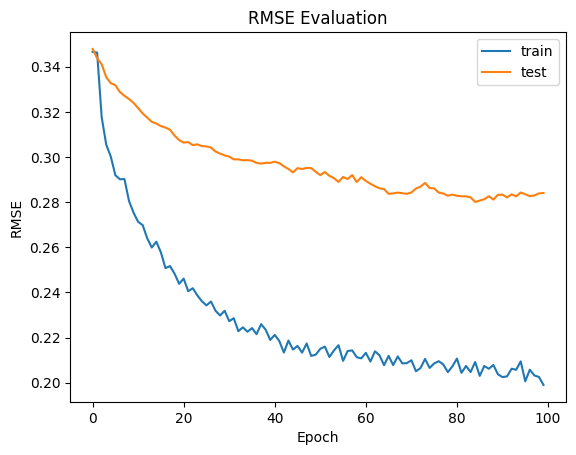

In [60]:
#Menampilkan grafik traning vs test
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE Evaluation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [53]:
def prepare_recommendation_data(df, phone_df, user_id, user_to_user_encoded, cellphone_to_cellphone_encoded):
    """
    Prepare data for recommending cellphones not reviewed by a specific user.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing user-cellphone interactions and reviews.
    - phone_df (pd.DataFrame): The DataFrame containing cellphone metadata.
    - user_id (int): The user ID for whom recommendations are to be prepared.
    - user_to_user_encoded (dict): Mapping of user IDs to encoded values.
    - cellphone_to_cellphone_encoded (dict): Mapping of cellphone IDs to encoded values.

    Returns:
    - user_cellphone_array (np.ndarray): Array of user and cellphone pairs for recommendation.
    - cellphone_not_reviewed (list): List of cellphones not reviewed by the user.
    """
    # Filter cellphones reviewed by the user
    cellphone_reviewed_by_user = df[df['user_id'] == user_id]
    
    # Get cellphones not reviewed by the user
    cellphone_not_reviewed = phone_df[~phone_df['cellphone_id'].isin(cellphone_reviewed_by_user['cellphone_id'].values)]['cellphone_id']
    
    # Keep only valid cellphone IDs that are in the encoding dictionary
    cellphone_not_reviewed = list(
        set(cellphone_not_reviewed)
        .intersection(set(cellphone_to_cellphone_encoded.keys()))
    )
    
    # Encode cellphones
    cellphone_not_reviewed = [[cellphone_to_cellphone_encoded.get(x)] for x in cellphone_not_reviewed]
    
    # Encode user
    user_encoder = user_to_user_encoded.get(user_id)
    
    # Create user-cellphone array
    user_cellphone_array = np.hstack(
        ([[user_encoder]] * len(cellphone_not_reviewed), cellphone_not_reviewed)
    )
    
    print(f"User ID: {user_id} (Encoded: {user_encoder})")
    print(f"Total cellphones not reviewed by user: {len(cellphone_not_reviewed)}")
    
    return user_cellphone_array, cellphone_not_reviewed

# Usage
df = pd.read_csv('dataset/cellphones ratings.csv')
phone_df = phone_new
user_id_sample = df['user_id'].sample(1).iloc[0]

user_cellphone_array, cellphone_not_reviewed = prepare_recommendation_data(
    df=df,
    phone_df=phone_df,
    user_id=user_id_sample,
    user_to_user_encoded=user_to_user_encoded,
    cellphone_to_cellphone_encoded=cellphone_to_cellphone_encoded
)


User ID: 60 (Encoded: 23)
Total cellphones not reviewed by user: 23


In [55]:
def get_user_recommendations(
    df, 
    phone_df, 
    model, 
    user_to_user_encoded, 
    cellphone_to_cellphone_encoded, 
    cellphone_encoded_to_cellphone, 
    top_n=10
):
    """
    Generate cellphone recommendations for a randomly selected user.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing user ratings.
    - phone_df (pd.DataFrame): The DataFrame containing cellphone metadata.
    - model (tf.keras.Model): The trained recommendation model.
    - user_to_user_encoded (dict): Mapping from user IDs to encoded user IDs.
    - cellphone_to_cellphone_encoded (dict): Mapping from cellphone IDs to encoded cellphone IDs.
    - cellphone_encoded_to_cellphone (dict): Mapping from encoded cellphone IDs to original cellphone IDs.
    - top_n (int): Number of recommendations to return.

    Returns:
    - None: Prints the recommendations and highly rated cellphones from the user.
    """
    # Step 1: Randomly select a user
    user_id = df['user_id'].sample(1).iloc[0]
    print(f"Selected User ID: {user_id}")

    # Step 2: Get cellphones reviewed by the user
    cellphone_reviewed_by_user = df[df['user_id'] == user_id]

    # Step 3: Get cellphones not reviewed by the user
    cellphone_not_reviewed = phone_df[
        ~phone_df['cellphone_id'].isin(cellphone_reviewed_by_user['cellphone_id'].values)
    ]['cellphone_id']
    
    # Filter valid cellphones for recommendation
    cellphone_not_reviewed = list(
        set(cellphone_not_reviewed)
        .intersection(set(cellphone_to_cellphone_encoded.keys()))
    )
    
    # Encode cellphones
    cellphone_not_reviewed = [[cellphone_to_cellphone_encoded.get(x)] for x in cellphone_not_reviewed]

    # Encode user
    user_encoder = user_to_user_encoded.get(user_id)

    # Create user-cellphone pairs
    user_cellphone_array = np.hstack(
        ([[user_encoder]] * len(cellphone_not_reviewed), cellphone_not_reviewed)
    )

    # Step 4: Predict ratings
    ratings = model.predict(user_cellphone_array).flatten()

    # Step 5: Get top N recommendations
    top_ratings_indices = ratings.argsort()[-top_n:][::-1]
    recommended_cellphone_ids = [
        cellphone_encoded_to_cellphone.get(cellphone_not_reviewed[x][0]) for x in top_ratings_indices
    ]

    # Step 6: Display high-rated cellphones from the user
    print("\n=== High Ratings by User ===")
    top_cellphone_user = (
        cellphone_reviewed_by_user.sort_values(by='rating', ascending=False)
        .head(5)['cellphone_id'].values
    )
    cellphone_df_rows = phone_df[phone_df['cellphone_id'].isin(top_cellphone_user)]
    for row in cellphone_df_rows.itertuples():
        print(f"{row.brand}: {row.model}")

    # Step 7: Display top N recommendations
    print("\n=== Top Cellphone Recommendations ===")
    recommended_cellphone = phone_df[phone_df['cellphone_id'].isin(recommended_cellphone_ids)]
    for row in recommended_cellphone.itertuples():
        print(f"{row.brand}: {row.model}")


In [56]:
get_user_recommendations(
    df=df,
    phone_df=phone_df,
    model=model,
    user_to_user_encoded=user_to_user_encoded,
    cellphone_to_cellphone_encoded=cellphone_to_cellphone_encoded,
    cellphone_encoded_to_cellphone=cellphone_encoded_to_cellphone,
    top_n=5
)


Selected User ID: 251
1/1 [==============================] - 0s 244ms/step

=== High Ratings by User ===
Google: Pixel 6  
OnePlus: 10 Pro
Apple: iPhone 13
OnePlus: 10T
Apple: iPhone 13 Pro Max

=== Top Cellphone Recommendations ===
Vivo: X80 Pro
Apple: iPhone 13 Pro
Apple: iPhone SE (2022)
Apple: iPhone 13 Mini
Google: Pixel 6 Pro 


In [59]:
get_user_recommendations(
    df=df,
    phone_df=phone_df,
    model=model,
    user_to_user_encoded=user_to_user_encoded,
    cellphone_to_cellphone_encoded=cellphone_to_cellphone_encoded,
    cellphone_encoded_to_cellphone=cellphone_encoded_to_cellphone,
    top_n=5
)


Selected User ID: 10
1/1 [==============================] - 0s 24ms/step

=== High Ratings by User ===
Vivo: X80 Pro
Apple: iPhone 13 Pro
Samsung: Galaxy Z Fold 3
Samsung: Galaxy S22 Ultra
Apple: iPhone 13 Pro Max

=== Top Cellphone Recommendations ===
Oppo: Find X5 Pro
Apple: iPhone SE (2022)
Apple: iPhone 13
Apple: iPhone 13 Mini
Google: Pixel 6 Pro 
